Word2Vec# VINCENT VAN GOGH STANDARD DATA TEXT PROCESS

This script takes the gallery's text from the local data folder and process it to an standard representation with Natural Language Processing and Word2Vec methods.

The process goes as follows:

1. Load the CSV into a pandas DataFrame.
2. Transform text columns into words lists.
3. Clear the text to find tokens (remove stop words).
4. Save corpus complete dictionary.
4. Lemmatize the tokens to find stem words.
5. Execute Bag of Words to find vector representation (doc2bow).
6. Execute the mapping of tokens in the text to find vector representation (doc2idx).
7. Execute the Word 2 Vect standarization process with tf-idf method (TF-IDF: Term Frequency - Inverse Document Frequency).
8. Create the dense standard vector text representation.
9. Save the the resulting CSV from pandas DataFrame

The following Links were useful to create this proof of concept:

- Gensim Word2Vec Tutorial, URL: https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial#Getting-Started
- Gensim Core Concepts, URL: https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html
- Document similarity queries, URL: https://radimrehurek.com/gensim/similarities/docsim.html
- Tutorial 19: Text analysis with gensim, URL: https://statsmaths.github.io/stat289-f18/solutions/tutorial19-gensim.html
- Gensim TF-IDF model, URL: https://radimrehurek.com/gensim/models/tfidfmodel.html?highlight=tfidfmodel#module-gensim.models.tfidfmodel
- Gensim, Construct word<->id mappings, URL: https://radimrehurek.com/gensim/corpora/dictionary.html?highlight=doc2idx#gensim.corpora.dictionary.Dictionary.doc2idx
- tensorflow, Word2Vec, URL: https://www.tensorflow.org/tutorials/text/word2vec
- Introduction to Word Embeddings, URL: https://pub.towardsai.net/introduction-to-word-embedding-5ba5cf97d296
- Python for NLP: Working with the Gensim Library (Part 1), URL: https://stackabuse.com/python-for-nlp-working-with-the-gensim-library-part-1/
- Packt main github repository, URL: https://github.com/PacktPublishing
- Regex Complement, URL: https://stackoverflow.com/questions/3977455/how-do-i-turn-any-regex-into-an-complement-of-itself-without-complex-hand-editin


In [58]:
"""
* Copyright 2020, Maestria de Humanidades Digitales,
* Universidad de Los Andes
*
* Developed for the Msc graduation project in Digital Humanities
*
* This program is free software: you can redistribute it and/or modify
* it under the terms of the GNU General Public License as published by
* the Free Software Foundation, either version 3 of the License, or
* (at your option) any later version.
*
* This program is distributed in the hope that it will be useful,
* but WITHOUT ANY WARRANTY; without even the implied warranty of
* MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
* GNU General Public License for more details.
*
* You should have received a copy of the GNU General Public License
* along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

# ===============================
# native python libraries
# ===============================
import os
import copy
import sys
import csv
import re
import math
import pprint
import datetime
from collections import Counter
from subprocess import check_output

# ===============================
# extension python libraries
# ===============================
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from tensorflow.keras.utils import to_categorical
import gensim
from gensim import models
from gensim import matutils
from gensim import similarities
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# downloading nlkt data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# ===============================
# developed python libraries
# ===============================


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [59]:
# notebook varlable definitions
# root folder
dataf = "Data"

# subfolder with the OCR transcrived txt data
prepf = "Prep"

#  subfolder with the CSV files containing the ML pandas dataframe
stdf = "Std"

# subfolder for reports
reportf = "Reports"

# dataframe file extension
fext = "csv"

# dictionary extension
dext = "dict"

# basic name
small_base = "VVG-Gallery-Text-Data-Small"
large_base = "VVG-Gallery-Text-Data-Large"
painting_base = "VVG-Gallery-Text-Data-Paintings"

train_base = "VVG-Gallery-Text-Data"

# dataframe file name
small_fn = small_base + "." + fext
large_fn = large_base + "." + fext
painting_fn = painting_base + "." + fext

# report names
str_date = datetime.date.today().strftime("%d-%b-%Y")
small_report = small_base + "-" + str_date + "." + "html"
large_report = large_base + "-" + str_date + "." + "html"
painting_report = painting_base + "-" + str_date + "." + "html"

# images names
small_phi_img = small_base + "-" + str_date + "-phi." + "png"
large_phi_img = large_base + "-" + str_date + "-phi." + "png"
painting_phi_img = painting_base + "-" + str_date + "-phi." + "png"

small_coent_img = small_base + "-" + str_date + "-coent." + "png"
large_coent_img = large_base + "-" + str_date + "-coent." + "png"
painting_coent_img = painting_base + "-" + str_date + "-coent." + "png"

# columns i reallry need
# 'ID', 'F-number', 'JH-number', 'creator-date', 'creator-place', 'Dimensions', 'details', 'credits', 'MUS_TEXT'

# regex for _TEXT
text_re = u"(\w+_TEXT)"

# regex for ID
in_re = u"((ID{1})|([A-Z]+-number){1,3}|^(creator){1,3}|(Dimensions)|(details))"

# regex for others (URLs|Categories)
# For example, if you match numeric strings as [0-9]*, to match the entire string you'd prepend ^ and append $, but to use this technique to find the complement you'd need to write ^(?!^[0-9]*$).*$ - and the usual concatenation of such a negated regex is, as far as I can tell, undoable.
label_re = u"^(?!^((\w+_TEXT)|((ID{1})|([A-Z]+-number){1,3}|^(creator-\w+){1,3}|(Dimensions)|(details)))*$).*$"
# cat_re = u"(\w+_TEXT)|((ID{1})|([A-Z]+-number){1,3}|^(creator){1,3}|(Dimensions)|(details)|(credits))"
# cat_re = u"ID{1}(^\w+( \w+)*$)"

# default values
work_base, work_fn, work_report, work_phi_img, work_coent_img = small_base, small_fn, small_report, small_phi_img, small_coent_img
# work_base, work_fn, work_report, work_phi_img, work_coent_img = large_base, large_fn, large_report, large_phi_img, large_coent_img
# work_base, work_fn, work_report, work_phi_img, work_coent_img = painting_base, painting_fn, painting_report, painting_phi_img, painting_coent_img

## Loading Data

In [60]:
root_folder = os.getcwd()
root_folder = os.path.split(root_folder)[0]
root_folder = os.path.normpath(root_folder)
print(root_folder)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLData-Preparer


In [61]:
# loading the CSV file into pandas
# read an existing CSV fileto update the dataframe
fn_path = os.path.join(root_folder, dataf, prepf, work_fn)
print(fn_path)
text_df = pd.read_csv(
                fn_path,
                sep=",",
                encoding="utf-8",
                engine="python",
            )

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLData-Preparer\Data\Prep\VVG-Gallery-Text-Data-Small.csv


In [62]:
# text_df = pd.DataFrame(text_df)
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 56 columns):
 #   Column                                                                                              Non-Null Count  Dtype 
---  ------                                                                                              --------------  ----- 
 0   ID                                                                                                  59 non-null     object
 1   F-number                                                                                            59 non-null     object
 2   JH-number                                                                                           59 non-null     object
 3   creator-date                                                                                        59 non-null     object
 4   creator-place                                                                                       59 non-null     object
 

In [63]:
text_df.head(5)

ID F-number JH-number    creator-date creator-place  \
0  s0004V1962r   F0388r    JH0782        may 1885        nuenen   
1   s0006V1962    F0160    JH0722      april 1885        nuenen   
2   s0010V1962    F0174    JH0978   december 1885       antwerp   
3   s0056V1962   F0216a    JH1054       june 1886         paris   
4   s0058V1962    F0161    JH0788  march-may 1885        nuenen   

                                          Dimensions           details  \
0                                  43.5 cm x 36.2 cm     oil on canvas   
1  43.2 cm x 30.0 cm, 2.2 cm x 59.0 cm, 46.2 cm x...     oil on canvas   
2               50.5 cm x 39.8 cm, 68.1 cm x 57.7 cm     oil on canvas   
3               46.0 cm x 38.0 cm, 55.1 cm x 46.5 cm  oil on cardboard   
4                   45.5 cm x 33.0 cm, 60 cm x 48 cm     oil on canvas   

                                             credits  \
0  van gogh museum, amsterdam (vincent van gogh f...   
1  van gogh museum, amsterdam (vincent van gogh f...   
2  van gogh museum, amsterdam (vincent van gogh f...   
3  van gogh museum, amsterdam (vincent van gogh f...   
4  van gogh museum, amsterdam (vincent van gogh f...   

                                            MUS_TEXT  \
0  head of a woman  with his brother theo van gog...   
1  head of a woman this woman is gordina de groot...   
2  portrait of an old woman the old womans grey h...   
3  torso of venus van gogh was thorough in everyt...   
4  woman with a mourning shawl here, van gogh was...   

                                               heads  ...       1881  \
0  https://vangoghmuseum.nl/en/collection?genre=h...  ...  localhost   
1  https://vangoghmuseum.nl/en/collection?genre=h...  ...  localhost   
2                                          localhost  ...  localhost   
3                                          localhost  ...  localhost   
4  https://vangoghmuseum.nl/en/collection?genre=h...  ...  localhost   

        1884                                              1885  \
0  localhost  https://vangoghmuseum.nl/en/collection?date=1885   
1  localhost  https://vangoghmuseum.nl/en/collection?date=1885   
2  localhost  https://vangoghmuseum.nl/en/collection?date=1885   
3  localhost                                         localhost   
4  localhost  https://vangoghmuseum.nl/en/collection?date=1885   

                                               1886       1887       1890  \
0                                         localhost  localhost  localhost   
1                                         localhost  localhost  localhost   
2                                         localhost  localhost  localhost   
3  https://vangoghmuseum.nl/en/collection?date=1886  localhost  localhost   
4                                         localhost  localhost  localhost   

                                              Nuenen  \
0  https://vangoghmuseum.nl/en/collection?place=n...   
1  https://vangoghmuseum.nl/en/collection?place=n...   
2                                          localhost   
3                                          localhost   
4  https://vangoghmuseum.nl/en/collection?place=n...   

                                             Antwerp  \
0                                          localhost   
1                                          localhost   
2  https://vangoghmuseum.nl/en/collection?place=a...   
3                                          localhost   
4                                          localhost   

                                               Paris   Brussels  
0                                          localhost  localhost  
1                                          localhost  localhost  
2                                          localhost  localhost  
3  https://vangoghmuseum.nl/en/collection?place=p...  localhost  
4                                          localhost  localhost  

[5 rows x 56 columns]

In [64]:
# getting the df columns
df_cols = list(text_df.columns.values)

# getting the text columns
text_r = re.compile(text_re)
text_cols = list(filter(text_r.match, df_cols))

# getting the ID column
in_r = re.compile(in_re)
in_cols = list(filter(in_r.match, df_cols))

# getting the URLs/Category columns
label_r = re.compile(label_re)
label_cols = list(filter(label_r.match, df_cols))
label_cols = sorted(label_cols, reverse=False) # .sort(key=str)
df_cols = in_cols + text_cols + label_cols

In [65]:
print("df columns:\n", df_cols)
print("text column:\n", text_cols)
print("basic columns:\n", in_cols)
print("label columns:\n", label_cols)
print("ordered df columns:\n", df_cols)

df columns:
 ['ID', 'F-number', 'JH-number', 'creator-date', 'creator-place', 'Dimensions', 'details', 'MUS_TEXT', '1881', '1884', '1885', '1886', '1887', '1890', 'Antwerp', 'Brussels', 'He would use this technique more than once in his later work', 'Head of a Man', 'Head of a Prostitute', 'Head of a Woman', 'Head of a Woman 1', 'Head of a Woman 2', 'Head of a Woman 3', 'Head of a Woman 4', 'Head of an Old Man', 'Horse', 'Kneeling Ecorche', 'Letter from Vincent van Gogh to Theo van Gogh with sketches of Head of a Woman and Head of a Woman', 'Male Torso', 'Nuenen', 'Paris', 'Plaster Cast of a Womans Torso', 'Plaster Cast of a Womans Torso 1', 'Portrait of a Prostitute', 'The Potato Eaters', 'Torso of Venus', 'Torso of Venus 1', 'Torso of Venus 2', 'Torso of Venus 3', 'Van Gogh wrote', 'Woman Sewing', 'animal art', 'cityscape', 'complementary colours', 'credits', 'drawing', 'drew', 'he wrote', 'heads', 'nude', 'painting', 'portrait', 'standing torso of Venus', 'still life', 'this torso o

## Column reshufle

In [66]:
target_cols = ['creator-date', 'creator-place', 'Dimensions', 'details',]
text_df = text_df.reindex(columns=df_cols)
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 56 columns):
 #   Column                                                                                              Non-Null Count  Dtype 
---  ------                                                                                              --------------  ----- 
 0   ID                                                                                                  59 non-null     object
 1   F-number                                                                                            59 non-null     object
 2   JH-number                                                                                           59 non-null     object
 3   creator-date                                                                                        59 non-null     object
 4   creator-place                                                                                       59 non-null     object
 

## Data Profiling

In [67]:
# pandas profile
interest_cols = list(target_cols + text_cols + label_cols)
interest_df = pd.DataFrame(text_df, columns=interest_cols)
profile = ProfileReport(interest_df, title="Pandas Profiling Report", explorative=True, dark_mode=True)

In [68]:
rfp = os.path.join(root_folder, dataf, reportf, work_report)
print(os.path.exists(rfp))
print(rfp)

False
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLData-Preparer\Data\Reports\VVG-Gallery-Text-Data-Small-06-Jun-2021.html


In [69]:
# saving profile
profile.to_file(rfp)

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 83.33it/s]


### Normal Phi() Analysis

In [70]:
# calculating correlation phik
phik_overview = text_df.phik_matrix()

In [71]:
# usefull render function
def render_heatmap(overview_df, fs):
    fig, ax = plt.subplots(figsize=fs)
    sns.set(font_scale = 1.25)
    heatmap = sns.heatmap(overview_df, ax = ax, annot = True, fmt = ".2f", cmap="BuPu")
    # sns_hm.set_title("Van Gogh's Museum Text Phi-k Profile", fontsize = 60, bottom = True)
    heatmap.tick_params(axis='both', 
                        which='major', 
                        labelbottom = False, 
                        bottom=False, 
                        top = False, 
                        labeltop=True, 
                        labelsize = 20)
    heatmap.set_xticklabels(overview_df.columns, rotation = 90)
    plt.tight_layout()
    return fig, ax, heatmap
    # plt.show() 

In [72]:
# rendering heatmap
fig, ax, heatmap = render_heatmap(phik_overview, (120, 120))
plt.show()

In [73]:
# saving image in png file
img_fpn = os.path.join(root_folder, dataf, reportf, work_phi_img)
print(os.path.exists(img_fpn))
print(img_fpn)

False
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLData-Preparer\Data\Reports\VVG-Gallery-Text-Data-Small-06-Jun-2021-phi.png


In [74]:
# saving rendered image
fig.savefig(img_fpn, dpi = fig.dpi)

### Conditional Entropy Analysis

Ok, that's good. That's really good. Being unable to distinguish mushrooms can be deadly.

Time to start diving deeper into the data. Let's see if there's a feature that can a better notion about the mushromm's class. More formealy, we want to know if there's a certain feature that maximizes the information about the class. For this, we will use Theil's U, also known as the Uncertainty Coefficient. Formaly marked as U(x|y), this coefficient provides a value in the range of \[0, 1\], where 0 means that feature y provides no information about feature x, and 1 means that feature y provides full information abpout features x's value.

https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival

https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9


In [75]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [76]:
def theilu_overview(interest_df):

    rows = interest_df.columns
    theilu_matrix = list()
    for i in range(0, len(rows)):
        t_theilu = pd.DataFrame(index=[rows[i]], columns=interest_df.columns)
        columns = interest_df.columns
        for j in range(0,len(columns)):
            u = theil_u(interest_df[rows[i]].tolist(),interest_df[columns[j]].tolist())
            t_theilu.loc[:,columns[j]] = u
        t_theilu.fillna(value=np.nan,inplace=True)
        t_theilu = copy.deepcopy(t_theilu.values[0].tolist())
        # print(t_theilu)
        theilu_matrix.append(t_theilu)

    theilu_matrix = np.asarray(theilu_matrix)
    # theilu_matrix.shape
    theilu_df = pd.DataFrame(theilu_matrix, index=rows, columns=rows)
        # print(len(t_theilu.columns))
    return theilu_df

In [77]:
theilu_report = theilu_overview(interest_df)

In [78]:
# rendering heatmap
fig, ax, heatmap = render_heatmap(theilu_report, (120, 120))
plt.show()

In [79]:
# saving image in png file
img_fpn = os.path.join(root_folder, dataf, reportf, work_coent_img)
print(os.path.exists(img_fpn))
print(img_fpn)

False
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLData-Preparer\Data\Reports\VVG-Gallery-Text-Data-Small-06-Jun-2021-coent.png


In [80]:
# saving rendered image
fig.savefig(img_fpn, dpi = fig.dpi)

### Reducing Dataset

In [81]:
keep_cols = in_cols + text_cols
print("keeping the columns:\n", keep_cols)

keeping the columns:
 ['ID', 'F-number', 'JH-number', 'creator-date', 'creator-place', 'Dimensions', 'details', 'MUS_TEXT']


In [82]:
train_df = pd.DataFrame(data=text_df[keep_cols].values, columns = keep_cols)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             59 non-null     object
 1   F-number       59 non-null     object
 2   JH-number      59 non-null     object
 3   creator-date   59 non-null     object
 4   creator-place  59 non-null     object
 5   Dimensions     59 non-null     object
 6   details        59 non-null     object
 7   MUS_TEXT       59 non-null     object
dtypes: object(8)
memory usage: 3.8+ KB


In [83]:
profile = ProfileReport(train_df, title="Pandas Profiling Report", explorative=True, dark_mode=True)

In [84]:
# creating new report file name
rfp = os.path.join(root_folder, dataf, reportf, work_report)
rfp = rfp.replace(work_base, train_base)
print(os.path.exists(rfp))
print(rfp)

True
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLData-Preparer\Data\Reports\VVG-Gallery-Text-Data-06-Jun-2021.html


In [85]:
# saving profile
profile.to_file(rfp)

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 249.90it/s]


In [86]:
# calculating correlation phik
phik_overview = train_df.phik_matrix()

In [87]:
# saving image in png file
img_fpn = os.path.join(root_folder, dataf, reportf, work_phi_img)
img_fpn = img_fpn.replace(work_base, train_base)
print(os.path.exists(img_fpn))
print(img_fpn)

True
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLData-Preparer\Data\Reports\VVG-Gallery-Text-Data-06-Jun-2021-phi.png


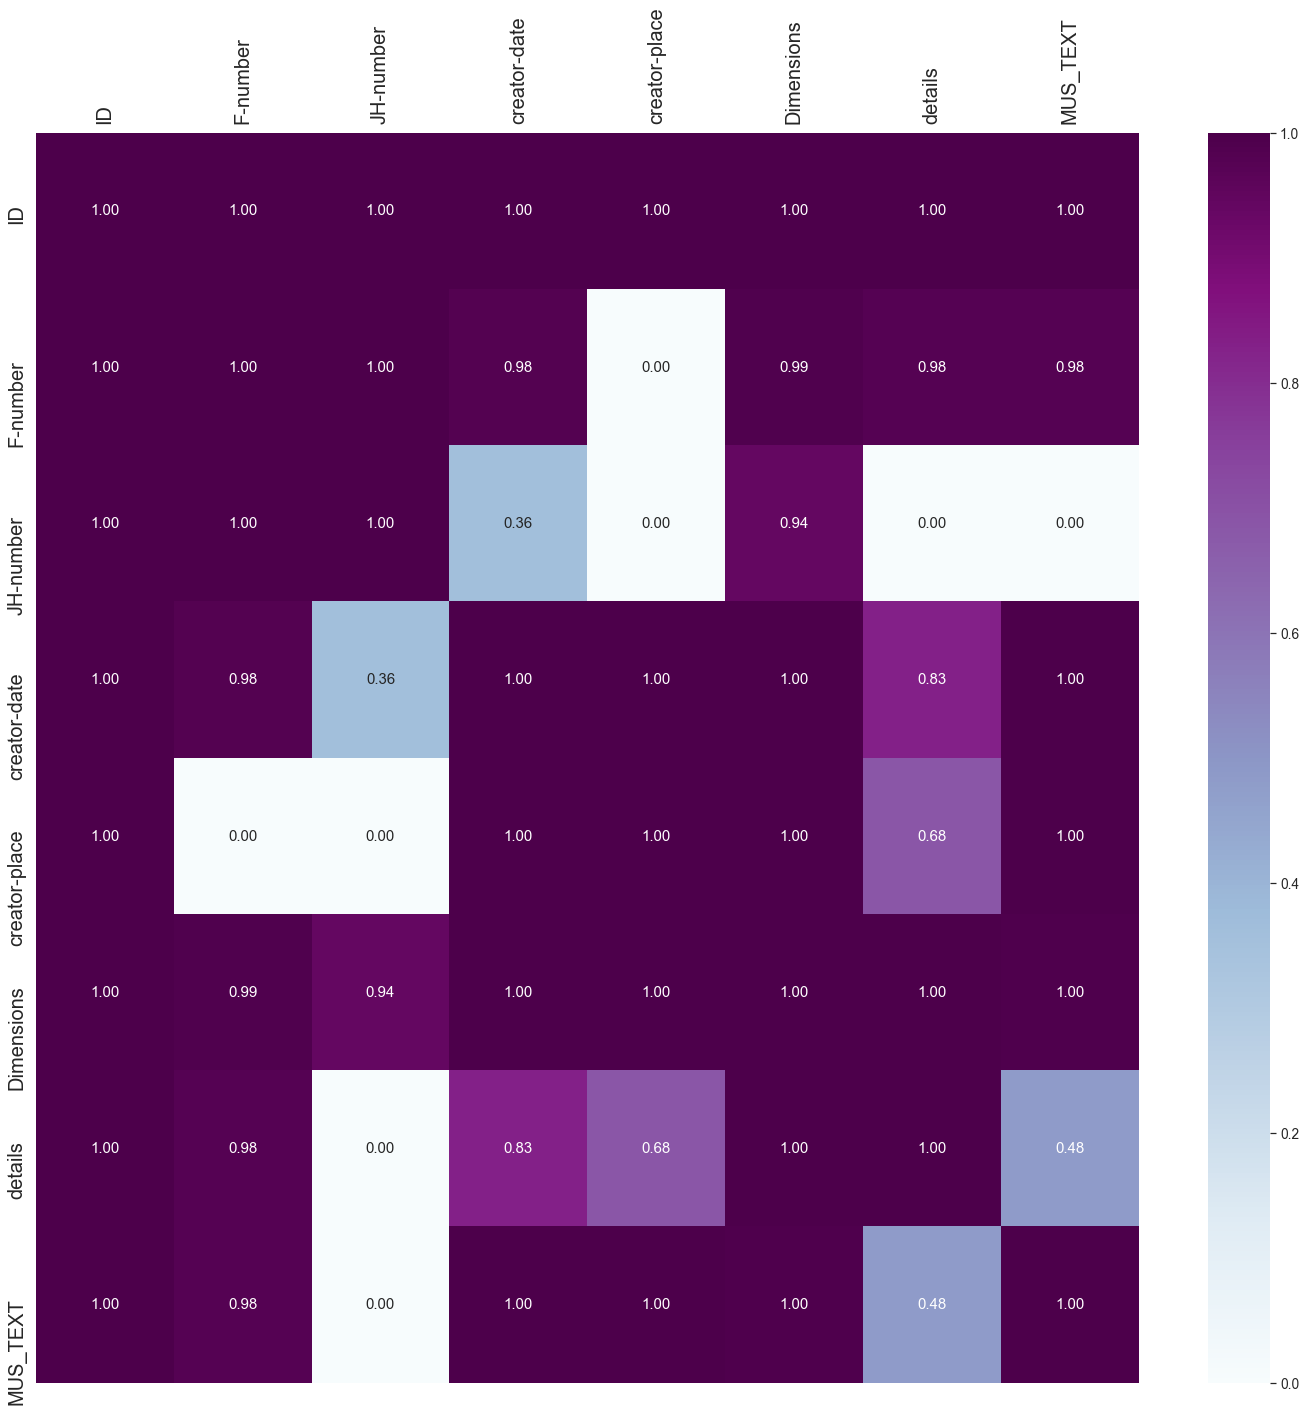

In [88]:
# rendering heatmap
fig, ax, heatmap = render_heatmap(phik_overview, (20, 20))
plt.show()

In [89]:
# saving rendered image
fig.savefig(img_fpn, dpi = fig.dpi)

In [90]:
#rendering conditional entropy
theilu_report = theilu_overview(train_df)

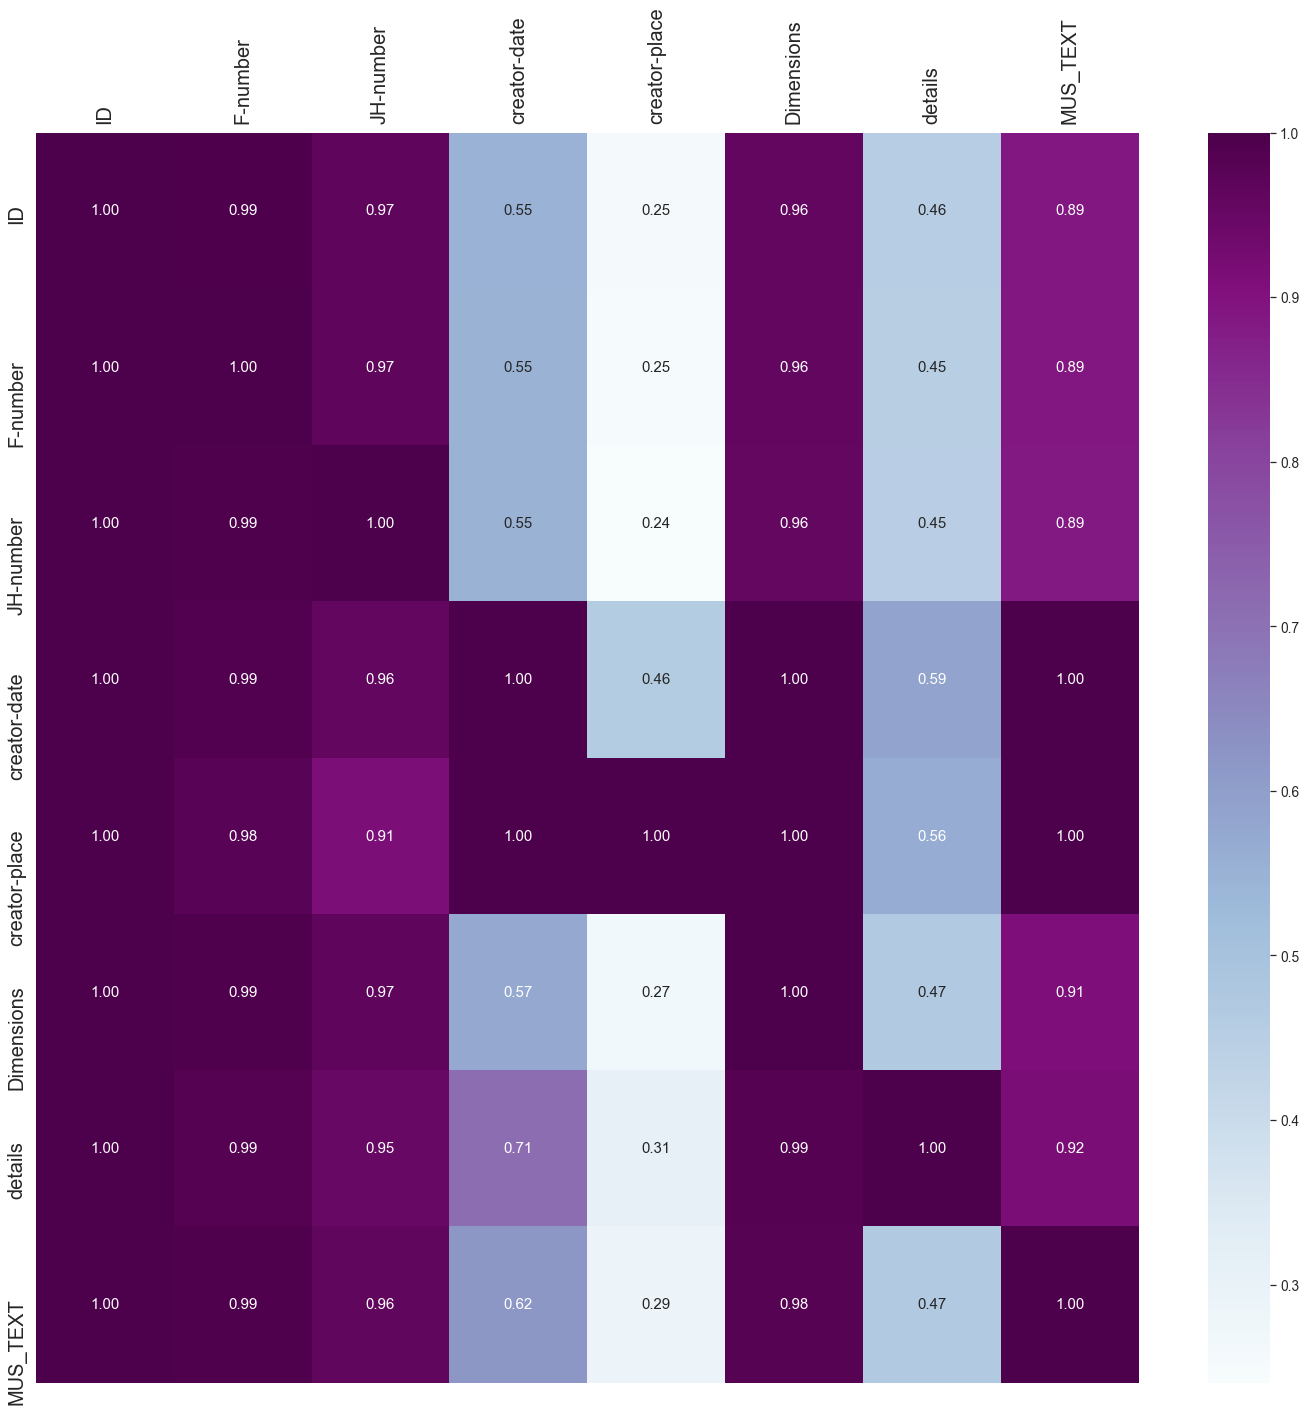

In [91]:
# rendering heatmap
fig, ax, heatmap = render_heatmap(theilu_report, (20, 20))
plt.show()

In [92]:
# saving image in png file
img_fpn = os.path.join(root_folder, dataf, reportf, work_coent_img)
img_fpn = img_fpn.replace(work_base, train_base)
print(os.path.exists(img_fpn))
print(img_fpn)

True
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLData-Preparer\Data\Reports\VVG-Gallery-Text-Data-06-Jun-2021-coent.png


In [93]:
# saving rendered image
fig.savefig(img_fpn, dpi = fig.dpi)

In [94]:
cat_labels = ("creator-date", "creator-place", "Dimensions", "details")
target_df = pd.DataFrame(train_df)

for cat in cat_labels:

    # changing the type column to category
    tcol = target_df[cat].astype('category')
    target_df[cat] = tcol
    cat_count = len(tcol.cat.categories.values)

    # creating the category code column
    tcol = target_df[cat].cat.codes
    target_df[str("std_cat_" + cat)] = tcol
    tcol = target_df[str("std_cat_" + cat)]

    # creating the categry array for training
    cat_list = to_categorical(tcol, cat_count)
    target_df[str("std_cat_" + cat)] = cat_list.tolist()

In [95]:
target_df.head()

ID F-number JH-number    creator-date creator-place  \
0  s0004V1962r   F0388r    JH0782        may 1885        nuenen   
1   s0006V1962    F0160    JH0722      april 1885        nuenen   
2   s0010V1962    F0174    JH0978   december 1885       antwerp   
3   s0056V1962   F0216a    JH1054       june 1886         paris   
4   s0058V1962    F0161    JH0788  march-may 1885        nuenen   

                                          Dimensions           details  \
0                                  43.5 cm x 36.2 cm     oil on canvas   
1  43.2 cm x 30.0 cm, 2.2 cm x 59.0 cm, 46.2 cm x...     oil on canvas   
2               50.5 cm x 39.8 cm, 68.1 cm x 57.7 cm     oil on canvas   
3               46.0 cm x 38.0 cm, 55.1 cm x 46.5 cm  oil on cardboard   
4                   45.5 cm x 33.0 cm, 60 cm x 48 cm     oil on canvas   

                                            MUS_TEXT  \
0  head of a woman  with his brother theo van gog...   
1  head of a woman this woman is gordina de groot...   
2  portrait of an old woman the old womans grey h...   
3  torso of venus van gogh was thorough in everyt...   
4  woman with a mourning shawl here, van gogh was...   

                                std_cat_creator-date  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

       std_cat_creator-place  \
0  [0.0, 0.0, 0.0, 1.0, 0.0]   
1  [0.0, 0.0, 0.0, 1.0, 0.0]   
2  [1.0, 0.0, 0.0, 0.0, 0.0]   
3  [0.0, 0.0, 0.0, 0.0, 1.0]   
4  [0.0, 0.0, 0.0, 1.0, 0.0]   

                                  std_cat_Dimensions  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     std_cat_details  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...

In [96]:
mus_corpus = target_df[text_cols].values.astype(str)
mus_corpus = mus_corpus.reshape(-1)
mus_corpus = mus_corpus.astype(str).tolist()
print(len(mus_corpus))
print(type(mus_corpus[0]))

59
<class 'str'>


In [97]:
# text cleaner function
def clean_text(text):
    # removing special characters
    ans = re.sub(r"\W", " ", text)
    # finding missing points between numbers
    ans = re.sub(r"(\d{1,3}) (\d{1,2})", r"\1.\2", ans)
    # removing excessive spaces
    ans = re.sub(r"\s+", " ", ans)
    return ans

In [98]:
clean_corpus = list()

for text in mus_corpus:
    text = clean_text(text)
    clean_corpus.append(text)

# updating source corpus
target_df[text_cols[0]] = clean_corpus

In [99]:
# function to recover tokens in text
def prep_tokens(text):

    ans = list()
    # spliting into tokens
    tokens = text.split()

    # removing english stopwords
    for tok in tokens:
        if not tok in stopwords.words('english'):
            ans.append(tok)
    
    return ans

In [100]:
token_corpus = list()
mus_corpus = target_df[text_cols[0]]

for text in mus_corpus:
    tokens = prep_tokens(text)
    token_corpus.append(tokens)

target_df["clr_tokens"] = token_corpus

In [101]:
# lematization of tokens
def prep_lemmas(tokens):

    token_lematizer = WordNetLemmatizer()
    lemmas = list()

    for token in tokens:
        ans = token_lematizer.lemmatize(token)
        lemmas.append(ans)
    
    return lemmas

In [102]:
work_corpus = list()
work_column = target_df["clr_tokens"]

for tokens in work_column:
    lemmas = prep_lemmas(tokens)
    work_corpus.append(lemmas)

target_df["lemmas"] = work_corpus

In [103]:
target_df.head()

ID F-number JH-number    creator-date creator-place  \
0  s0004V1962r   F0388r    JH0782        may 1885        nuenen   
1   s0006V1962    F0160    JH0722      april 1885        nuenen   
2   s0010V1962    F0174    JH0978   december 1885       antwerp   
3   s0056V1962   F0216a    JH1054       june 1886         paris   
4   s0058V1962    F0161    JH0788  march-may 1885        nuenen   

                                          Dimensions           details  \
0                                  43.5 cm x 36.2 cm     oil on canvas   
1  43.2 cm x 30.0 cm, 2.2 cm x 59.0 cm, 46.2 cm x...     oil on canvas   
2               50.5 cm x 39.8 cm, 68.1 cm x 57.7 cm     oil on canvas   
3               46.0 cm x 38.0 cm, 55.1 cm x 46.5 cm  oil on cardboard   
4                   45.5 cm x 33.0 cm, 60 cm x 48 cm     oil on canvas   

                                            MUS_TEXT  \
0  head of a woman with his brother theo van gogh...   
1  head of a woman this woman is gordina de groot...   
2  portrait of an old woman the old womans grey h...   
3  torso of venus van gogh was thorough in everyt...   
4  woman with a mourning shawl here van gogh was ...   

                                std_cat_creator-date  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

       std_cat_creator-place  \
0  [0.0, 0.0, 0.0, 1.0, 0.0]   
1  [0.0, 0.0, 0.0, 1.0, 0.0]   
2  [1.0, 0.0, 0.0, 0.0, 0.0]   
3  [0.0, 0.0, 0.0, 0.0, 1.0]   
4  [0.0, 0.0, 0.0, 1.0, 0.0]   

                                  std_cat_Dimensions  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     std_cat_details  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   

                                          clr_tokens  \
0  [head, woman, brother, theo, van, gogh, paris,...   
1  [head, woman, woman, gordina, de, groot, posed...   
2  [portrait, old, woman, old, womans, grey, hair...   
3  [torso, venus, van, gogh, thorough, everything...   
4  [woman, mourning, shawl, van, gogh, practising...   

                                              lemmas  
0  [head, woman, brother, theo, van, gogh, paris,...  
1  [head, woman, woman, gordina, de, groot, posed...  
2  [portrait, old, woman, old, woman, grey, hair,...  
3  [torso, venus, van, gogh, thorough, everything...  
4  [woman, mourning, shawl, van, gogh, practising...

In [104]:
# saving gesim words dictionary
work_column = target_df["clr_tokens"]

vvg_dict = gensim.corpora.Dictionary(work_column)
print(vvg_dict)
work_dict = work_fn.split(".")
work_dict = work_dict[0] + "." + dext
dict_pfn = os.path.join(root_folder, dataf, stdf, work_dict)
print(dict_pfn)
vvg_dict.save(dict_pfn) 
# os.path.join("Data","VVG-gallery-text.dict"))
# pprint.pprint(vvg_dict.token2id)

Dictionary(599 unique tokens: ['1', '11', '16', '1885', '1891']...)
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLData-Preparer\Data\Std\VVG-Gallery-Text-Data-Small.dict


In [105]:
# function to get bag of words with a corpus dictionary
def prep_bows(lemmas, wdict):
    bows = wdict.doc2bow(lemmas, allow_update=True)
    return bows

# function to get de idxs with a corpus dictionary
def prep_idxs(lemmas, wdict):
    idxs = wdict.doc2idx(lemmas)
    return idxs

In [106]:
# creating vectorial word representation
work_corpus = list()
work_column = target_df["clr_tokens"]

for lemmas in work_column:

    bows = prep_bows(lemmas, vvg_dict)
    work_corpus.append(bows)

target_df["bows_tokens"] = work_corpus

In [107]:
# creating vectorial word representation
work_corpus = list()
work_column = target_df["clr_tokens"]

for lemmas in work_column:

    bows = prep_idxs(lemmas, vvg_dict)
    work_corpus.append(bows)

target_df["idxs_tokens"] = work_corpus

In [108]:
target_df.head()

ID F-number JH-number    creator-date creator-place  \
0  s0004V1962r   F0388r    JH0782        may 1885        nuenen   
1   s0006V1962    F0160    JH0722      april 1885        nuenen   
2   s0010V1962    F0174    JH0978   december 1885       antwerp   
3   s0056V1962   F0216a    JH1054       june 1886         paris   
4   s0058V1962    F0161    JH0788  march-may 1885        nuenen   

                                          Dimensions           details  \
0                                  43.5 cm x 36.2 cm     oil on canvas   
1  43.2 cm x 30.0 cm, 2.2 cm x 59.0 cm, 46.2 cm x...     oil on canvas   
2               50.5 cm x 39.8 cm, 68.1 cm x 57.7 cm     oil on canvas   
3               46.0 cm x 38.0 cm, 55.1 cm x 46.5 cm  oil on cardboard   
4                   45.5 cm x 33.0 cm, 60 cm x 48 cm     oil on canvas   

                                            MUS_TEXT  \
0  head of a woman with his brother theo van gogh...   
1  head of a woman this woman is gordina de groot...   
2  portrait of an old woman the old womans grey h...   
3  torso of venus van gogh was thorough in everyt...   
4  woman with a mourning shawl here van gogh was ...   

                                std_cat_creator-date  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

       std_cat_creator-place  \
0  [0.0, 0.0, 0.0, 1.0, 0.0]   
1  [0.0, 0.0, 0.0, 1.0, 0.0]   
2  [1.0, 0.0, 0.0, 0.0, 0.0]   
3  [0.0, 0.0, 0.0, 0.0, 1.0]   
4  [0.0, 0.0, 0.0, 1.0, 0.0]   

                                  std_cat_Dimensions  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     std_cat_details  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   

                                          clr_tokens  \
0  [head, woman, brother, theo, van, gogh, paris,...   
1  [head, woman, woman, gordina, de, groot, posed...   
2  [portrait, old, woman, old, womans, grey, hair...   
3  [torso, venus, van, gogh, thorough, everything...   
4  [woman, mourning, shawl, van, gogh, practising...   

                                              lemmas  \
0  [head, woman, brother, theo, van, gogh, paris,...   
1  [head, woman, woman, gordina, de, groot, posed...   
2  [portrait, old, woman, old, woman, grey, hair,...   
3  [torso, venus, van, gogh, thorough, everything...   
4  [woman, mourning, shawl, van, gogh, practising...   

                                         bows_tokens  \
0  [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...   
1  [(0, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1...   
2  [(0, 1), (3, 1), (4, 1), (5, 1), (9, 2), (10, ...   
3  [(0, 1), (4, 1), (5, 1), (9, 2), (10, 2), (11,...   
4  [(0, 1), (3, 2), (4, 1), (5, 1), (9, 2), (10, ...   

                                         idxs_tokens  
0  [33, 65, 22, 58, 61, 32, 47, 43, 3, 59, 26, 15...  
1  [33, 65, 65, 82, 75, 84, 100, 79, 101, 77, 102...  
2  [140, 139, 65, 139, 149, 130, 131, 144, 148, 1...  
3  [180, 183, 61, 32, 178, 163, 161, 174, 96, 173...  
4  [65, 196, 201, 61, 32, 199, 96, 205, 189, 194,...

In [109]:
# train the model
corpus_idxs = target_df["idxs_tokens"].values.tolist()
corpus_bows = target_df["bows_tokens"].values.tolist()
tfidf = gensim.models.TfidfModel(corpus_idxs, dictionary=vvg_dict, normalize=True)
corpus_tfidf = tfidf[corpus_bows]
target_df["tfidf_tokens"] = corpus_tfidf

C:\Program Files\Python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [110]:
# saving tfidf model for future use
work_column = target_df["clr_tokens"]

work_model = work_fn.split(".")
work_model = work_model[0] + "." + "gensim"
model_pfn = os.path.join(root_folder, dataf, stdf, work_model)
print(model_pfn)
tfidf.save(model_pfn) 
# os.path.join("Data","VVG-gallery-text.dict"))
# pprint.pprint(vvg_dict.token2id)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLData-Preparer\Data\Std\VVG-Gallery-Text-Data-Small.gensim


In [111]:
target_df.head()

ID F-number JH-number    creator-date creator-place  \
0  s0004V1962r   F0388r    JH0782        may 1885        nuenen   
1   s0006V1962    F0160    JH0722      april 1885        nuenen   
2   s0010V1962    F0174    JH0978   december 1885       antwerp   
3   s0056V1962   F0216a    JH1054       june 1886         paris   
4   s0058V1962    F0161    JH0788  march-may 1885        nuenen   

                                          Dimensions           details  \
0                                  43.5 cm x 36.2 cm     oil on canvas   
1  43.2 cm x 30.0 cm, 2.2 cm x 59.0 cm, 46.2 cm x...     oil on canvas   
2               50.5 cm x 39.8 cm, 68.1 cm x 57.7 cm     oil on canvas   
3               46.0 cm x 38.0 cm, 55.1 cm x 46.5 cm  oil on cardboard   
4                   45.5 cm x 33.0 cm, 60 cm x 48 cm     oil on canvas   

                                            MUS_TEXT  \
0  head of a woman with his brother theo van gogh...   
1  head of a woman this woman is gordina de groot...   
2  portrait of an old woman the old womans grey h...   
3  torso of venus van gogh was thorough in everyt...   
4  woman with a mourning shawl here van gogh was ...   

                                std_cat_creator-date  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

       std_cat_creator-place  \
0  [0.0, 0.0, 0.0, 1.0, 0.0]   
1  [0.0, 0.0, 0.0, 1.0, 0.0]   
2  [1.0, 0.0, 0.0, 0.0, 0.0]   
3  [0.0, 0.0, 0.0, 0.0, 1.0]   
4  [0.0, 0.0, 0.0, 1.0, 0.0]   

                                  std_cat_Dimensions  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     std_cat_details  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   

                                          clr_tokens  \
0  [head, woman, brother, theo, van, gogh, paris,...   
1  [head, woman, woman, gordina, de, groot, posed...   
2  [portrait, old, woman, old, womans, grey, hair...   
3  [torso, venus, van, gogh, thorough, everything...   
4  [woman, mourning, shawl, van, gogh, practising...   

                                              lemmas  \
0  [head, woman, brother, theo, van, gogh, paris,...   
1  [head, woman, woman, gordina, de, groot, posed...   
2  [portrait, old, woman, old, woman, grey, hair,...   
3  [torso, venus, van, gogh, thorough, everything...   
4  [woman, mourning, shawl, van, gogh, practising...   

                                         bows_tokens  \
0  [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...   
1  [(0, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1...   
2  [(0, 1), (3, 1), (4, 1), (5, 1), (9, 2), (10, ...   
3  [(0, 1), (4, 1), (5, 1), (9, 2), (10, 2), (11,...   
4  [(0, 1), (3, 2), (4, 1), (5, 1), (9, 2), (10, ...   

                                         idxs_tokens  \
0  [33, 65, 22, 58, 61, 32, 47, 43, 3, 59, 26, 15...   
1  [33, 65, 65, 82, 75, 84, 100, 79, 101, 77, 102...   
2  [140, 139, 65, 139, 149, 130, 131, 144, 148, 1...   
3  [180, 183, 61, 32, 178, 163, 161, 174, 96, 173...   
4  [65, 196, 201, 61, 32, 199, 96, 205, 189, 194,...   

                                        tfidf_tokens  
0  [(0, 0.0016540840177406216), (1, 0.23881715780...  
1  [(0, 0.0006867329088719676), (2, 0.10811503089...  
2  [(0, 0.0007612234008171606), (3, 0.05286506325...  
3  [(0, 0.0009062431787609751), (4, 0.00182824789...  


In [112]:
# function to create dense std text representation with idxs and tfidf tokens
def prep_dense_stdvec(idxs_tokens, tfidf_tokens):

    # dense vector representation
    tdvect = list()

    # creating the dense representation for each text
    for t_token in idxs_tokens:

        # transforming the tfidf into dict
        tokens_dict = dict(tfidf_tokens)
        
        # looking for each word
        if t_token in tokens_dict.keys():
            temp = tokens_dict.get(t_token)
            # appending std word representation into array
            tdvect.append(temp)

    # copying std dense vector into corpus column
    ans = copy.deepcopy(tdvect)
    return ans

In [113]:
# creating the dense vector standar representantion of the text
corpus_stdvec = list()

# iterating in each text with the tfidf word bag
for idxs_tokens, tfidf_tokens in zip(corpus_idxs, corpus_tfidf):

    tdvect = prep_dense_stdvec(idxs_tokens, tfidf_tokens)
    corpus_stdvec.append(tdvect)

target_df["std_dvec_tokens"] = corpus_stdvec

In [114]:
# checking everything is okey
target_df.head()

ID F-number JH-number    creator-date creator-place  \
0  s0004V1962r   F0388r    JH0782        may 1885        nuenen   
1   s0006V1962    F0160    JH0722      april 1885        nuenen   
2   s0010V1962    F0174    JH0978   december 1885       antwerp   
3   s0056V1962   F0216a    JH1054       june 1886         paris   
4   s0058V1962    F0161    JH0788  march-may 1885        nuenen   

                                          Dimensions           details  \
0                                  43.5 cm x 36.2 cm     oil on canvas   
1  43.2 cm x 30.0 cm, 2.2 cm x 59.0 cm, 46.2 cm x...     oil on canvas   
2               50.5 cm x 39.8 cm, 68.1 cm x 57.7 cm     oil on canvas   
3               46.0 cm x 38.0 cm, 55.1 cm x 46.5 cm  oil on cardboard   
4                   45.5 cm x 33.0 cm, 60 cm x 48 cm     oil on canvas   

                                            MUS_TEXT  \
0  head of a woman with his brother theo van gogh...   
1  head of a woman this woman is gordina de groot...   
2  portrait of an old woman the old womans grey h...   
3  torso of venus van gogh was thorough in everyt...   
4  woman with a mourning shawl here van gogh was ...   

                                std_cat_creator-date  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

       std_cat_creator-place  \
0  [0.0, 0.0, 0.0, 1.0, 0.0]   
1  [0.0, 0.0, 0.0, 1.0, 0.0]   
2  [1.0, 0.0, 0.0, 0.0, 0.0]   
3  [0.0, 0.0, 0.0, 0.0, 1.0]   
4  [0.0, 0.0, 0.0, 1.0, 0.0]   

                                  std_cat_Dimensions  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     std_cat_details  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...   

                                          clr_tokens  \
0  [head, woman, brother, theo, van, gogh, paris,...   
1  [head, woman, woman, gordina, de, groot, posed...   
2  [portrait, old, woman, old, womans, grey, hair...   
3  [torso, venus, van, gogh, thorough, everything...   
4  [woman, mourning, shawl, van, gogh, practising...   

                                              lemmas  \
0  [head, woman, brother, theo, van, gogh, paris,...   
1  [head, woman, woman, gordina, de, groot, posed...   
2  [portrait, old, woman, old, woman, grey, hair,...   
3  [torso, venus, van, gogh, thorough, everything...   
4  [woman, mourning, shawl, van, gogh, practising...   

                                         bows_tokens  \
0  [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...   
1  [(0, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1...   
2  [(0, 1), (3, 1), (4, 1), (5, 1), (9, 2), (10, ...   
3  [(0, 1), (4, 1), (5, 1), (9, 2), (10, 2), (11,...   
4  [(0, 1), (3, 2), (4, 1), (5, 1), (9, 2), (10, ...   

                                         idxs_tokens  \
0  [33, 65, 22, 58, 61, 32, 47, 43, 3, 59, 26, 15...   
1  [33, 65, 65, 82, 75, 84, 100, 79, 101, 77, 102...   
2  [140, 139, 65, 139, 149, 130, 131, 144, 148, 1...   
3  [180, 183, 61, 32, 178, 163, 161, 174, 96, 173...   
4  [65, 196, 201, 61, 32, 199, 96, 205, 189, 194,...   

                                        tfidf_tokens  \
0  [(0, 0.0016540840177406216), (1, 0.23881715780...   
1  [(0, 0.0006867329088719676), (2, 0.10811503089...   
2  [(0, 0.0007612234008171606), (3, 0.05286506325...   
3  [(0, 0.0009062431787609751), (4, 0.00182824789..

In [116]:
target_df["tfidf_tokens"][0]

[(0, 0.0016540840177406216),
 (1, 0.23881715780765045),
 (2, 0.2604088756571289),
 (3, 0.11487200226909956),
 (4, 0.003336936151865878),
 (5, 0.003336936151865878),
 (6, 0.2604088756571289),
 (7, 0.23881715780765045),
 (8, 0.20625957971713113),
 (9, 0.003308168035481243),
 (10, 0.003308168035481243),
 (11, 0.0016540840177406216),
 (12, 0.4776343156153009),
 (13, 0.004962252053221865),
 (14, 0.006673872303731756),
 (15, 0.003336936151865878),
 (16, 0.18194200390108842),
 (17, 0.23881715780765045),
 (18, 0.003336936151865878),
 (19, 0.003336936151865878),
 (21, 0.006673872303731756),
 (22, 0.003336936151865878),
 (23, 0.003336936151865878),
 (24, 0.0016540840177406216),
 (25, 0.003336936151865878),
 (27, 0.2783791561702846),
 (28, 0.4423508795582173),
 (29, 0.003336936151865878),
 (30, 0.00992450410644373),
 (31, 0.003308168035481243),
 (33, 0.15410543814711977),
 (36, 0.006673872303731756),
 (37, 0.004962252053221865),
 (38, 0.003308168035481243),
 (39, 0.013347744607463512),
 (40, 0.00

In [123]:
tfidf
# .id2word(target_df["std_dvec_tokens"][0],1)

In [115]:
# saving the CSV file into pandas
# writing an existing CSV fileto update the dataframe
target_fn = "std-" + work_fn
fn_tpath = os.path.join(root_folder, dataf, stdf, target_fn)
print(fn_tpath)
target_df.to_csv(fn_tpath,
                sep=",",
                index=False,
                encoding="utf-8",
                mode="w",
                )

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLData-Preparer\Data\Std\std-VVG-Gallery-Text-Data-Small.csv
